# Рыков Елисей
### Функциональные модели. Домашнее задание 1

https://github.com/dashapopova/FunctionalModelsCompLing/blob/main/HWs/hw1.md

# Экспорт данных

1. В качестве исходных данных был взят датасет Amazon, посвященный спортивным товарам
2. В датасете есть описание товара и оценка (от 1 до 5)
3. Датасет насчитывает более 296 тысяч строк

In [33]:
import pandas as pd

df = pd.read_json('data.json', lines=True)[['reviewText', 'overall']]
df.head()

,reviewText,overall
0,This came in on time and I am veru happy with ...,5
1,I had a factory Glock tool that I was using fo...,5
2,If you don't have a 3/32 punch or would like t...,4
3,This works no better than any 3/32 punch you w...,4
4,I purchased this thinking maybe I need a speci...,4


# Обработка и анализ данных

В качестве экспрессива я выбрал слово "totally". Я полагаю, что при оценочной разметке от 1 до 5 он будет иметь U-образный профиль, так как мне кажется, что люди чаще употребляют его либо при большом восторге (оценка 5: "Полностью рекомендую", "Совершенно идеальный товар"...), либо при большом разочаровании (оценка 1, 2: "Совершенно не рекомендую к покупке", "Полностью не понимаю как это можно продать"...) для подчеркивания своей сильной эмоции. 


Ниже приведено распределение отзывов по оценкам – заметно, что оценок "5" больше всего:

|Оценка|Количество отзывов|
|------|------------------|
|5    |188208|
|4    | 64809|
|3    | 24071|
|2    | 10204|
|1    |  9045|


Примеры употребления экспрессива:

|Оценка|Пример употребления в отзыве|
|------|-----|
|1|I is totally worth it to spend just a little more and get something better!|
|2|The valves on the extra wide are totally different|
|3|I don\'t think I\'d recommend it for practice because of the totally inconsistent ball return|
|4|This is one of those purchases that ended up totally working out, just not how I thought, as this thing is always with mein my day to day routine|
|5|I totally recommend these as being Fantastic Binoculars|

In [3]:
import re
import nltk
from nltk.corpus import stopwords

def text_prepare(text):
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, "", text)
    text = re.sub(BAD_SYMBOLS_RE, "", text)
    text = " ".join([word for word in text.split() if word not in STOPWORDS])
    return text

nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

df['reviewText'] = df['reviewText'].apply(text_prepare)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elisejzelihovskij/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Построение профиля

In [25]:
from collections import Counter
from itertools import chain
import math

expressive = 'totally'
expressive_len = len(expressive)
logs = []
rating = [1, 2, 3, 4, 5]

for r in rating:
    lemmatized = df[df['overall'] == r]['reviewText'].str.split()
    lemmatized = lemmatized.to_numpy()

    freq = Counter(chain(*[x for x in lemmatized]))
    expressives_with_same_len = []
    for key in freq.keys():
        if len(key) == expressive_len:
            expressives_with_same_len.append(key)
    r1 = freq[expressive]
    r2 = 0
    for key in expressives_with_same_len:
        r2 += freq[key]
    log_odds = math.log(r1/(r2-r1))
    logs.append(log_odds)
    print(f"R={r}, r1={r1}, r2={r2}")

R=1, r1=147, r2=52493
R=2, r1=95, r2=62104
R=3, r1=177, r2=139047
R=4, r1=411, r2=363026
R=5, r1=1356, r2=866659


In [26]:
from matplotlib import pyplot as plt

Действительно, профиль напоминает U-образный: в оценке 5 экспрессив "totally" встречается чаще, чем в оценках 4, 3 и 2, но реже, чем в оценке 1:

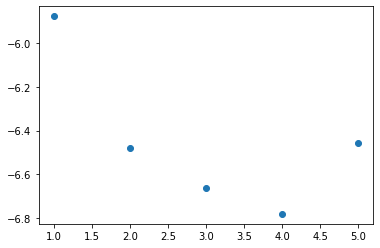

In [27]:
plt.scatter(rating, logs)

# Аппроксимация
Построим линию регрессии и аппроксимируем при помощи полиномиальной регрессии:

In [28]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(np.array(rating).reshape(-1, 1), np.array(logs).reshape(-1,1))

In [29]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(), Ridge(alpha=1e-10))
model.fit(np.array(rating).reshape(-1, 1), np.array(logs).reshape(-1,1))

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1e-10, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

Полиномиальная регрессия лучше линейной аппроксимирует получившийся профиль:

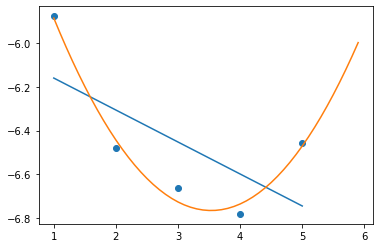

In [57]:
plt.scatter(rating, logs)

plt.plot(rating, lr.predict(np.array(rating).reshape(-1, 1)))
plt.plot(np.array(np.arange(1, 6, 0.1)).reshape(-1, 1),
         model.predict(np.array(np.arange(1, 6, 0.1)).reshape(-1, 1))
        )

# Выводы

Реже всего экспрессив "totally" упоминается в оценках 4. Вот несколько примеров употребления в таких отзывах – в них экспрессив применяется для описания товаров:

1. It is not totally water proof
2. It totally works as advertised
3. The knife is totally packable
4. No it does not make things totally water proof

При этом в оценках 1 и 5 люди часто употребляют "totally" для описания себя и своих эмоций. 

Оценка 1:
1. I'm so totally frustrated right now I could sweat blood
2. I was totally disappointed accept for the fancy embroidery but not enough to keep it - I sent it back
3. Granted I spent $10, so I am not totally disappointed
4. What it doesn't have that i'm totally accustomed to is a back light and a calendar

Оценка 5:
1. I would totally recommend this pump from The Friendly Swede to you
2. Believe me, I'm totally inept when it comes to assembling anything
3. I’m totally satisfied with it

В результате работы подтвердилась гипотеза о том, что экспрессив "totally" обладает U-образным экспрессивом. 